# Week 8 HW

In [5]:
# Download and extract the dataset
# !wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
# !unzip -q data.zip

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0
CUDA available: False


In [7]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
class HairTypeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Get sorted list of classes (folders)
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        print(f"Found classes: {self.classes}")
        print(f"Class to index mapping: {self.class_to_idx}")
        
        # Load all image paths and labels
        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            if not os.path.isdir(label_dir):
                continue
            
            for img_name in os.listdir(label_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(label_dir, img_name))
                    self.labels.append(self.class_to_idx[label_name])
        
        print(f"Total images loaded: {len(self.image_paths)}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
# Transformations for initial training (no augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )  # ImageNet normalization
])

# Same transforms for test set (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [10]:
# Create datasets
train_dataset = HairTypeDataset(
    data_dir='./data/train',
    transform=train_transforms
)

validation_dataset = HairTypeDataset(
    data_dir='./data/test',
    transform=test_transforms
)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")

Found classes: ['curly', 'straight']
Class to index mapping: {'curly': 0, 'straight': 1}
Total images loaded: 800
Found classes: ['curly', 'straight']
Class to index mapping: {'curly': 0, 'straight': 1}
Total images loaded: 201

Training samples: 800
Validation samples: 201


In [11]:
from torch.utils.data import DataLoader

batch_size = 20

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(validation_loader)}")

Number of training batches: 40
Number of validation batches: 11


Batch shape: torch.Size([20, 3, 200, 200])
Labels shape: torch.Size([20])
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1])


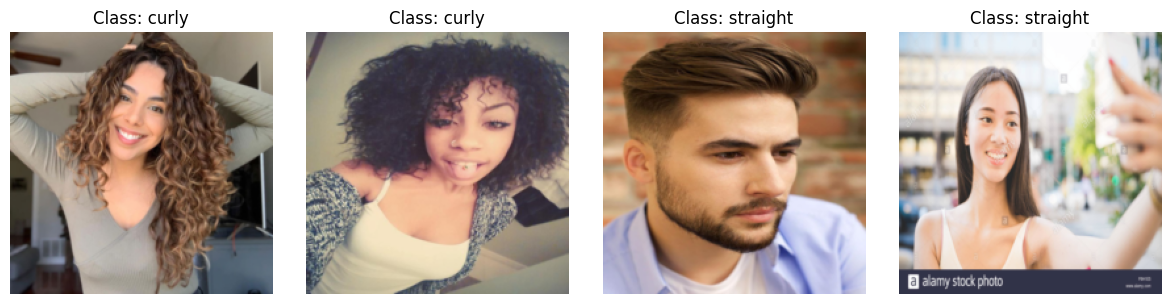

In [12]:
# Get a batch of training data
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Labels: {labels}")

# Visualize first few images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    # Denormalize for visualization
    img = images[i].permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Class: {train_dataset.classes[labels[i]]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class HairTypeCNN(nn.Module):
    def __init__(self):
        super(HairTypeCNN, self).__init__()
        
        # Convolutional layer: 3 input channels (RGB), 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        
        # Max pooling layer: 2x2 window
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate size after conv and pooling
        # Input: 200x200
        # After conv (3x3): 198x198 (200 - 3 + 1)
        # After pool (2x2): 99x99 (198 // 2)
        # Flattened: 32 * 99 * 99 = 313,632
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 99 * 99, 64)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        # No activation here - BCEWithLogitsLoss applies sigmoid internally
    
    def forward(self, x):
        # Input shape: (batch_size, 3, 200, 200)
        x = self.conv1(x)      # (batch_size, 32, 198, 198)
        x = self.relu1(x)      # (batch_size, 32, 198, 198)
        x = self.pool(x)       # (batch_size, 32, 99, 99)
        
        # Flatten
        x = x.view(x.size(0), -1)  # (batch_size, 32*99*99)
        
        x = self.fc1(x)        # (batch_size, 64)
        x = self.relu2(x)      # (batch_size, 64)
        x = self.fc2(x)        # (batch_size, 1)
        
        return x

In [14]:
# Create model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = HairTypeCNN()
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Detailed breakdown
print("\nParameter breakdown:")
for name, param in model.named_parameters():
    print(f"{name:20s} {param.shape} -> {param.numel():,} parameters")

Using device: cpu

Total parameters: 20,073,473
Trainable parameters: 20,073,473

Parameter breakdown:
conv1.weight         torch.Size([32, 3, 3, 3]) -> 864 parameters
conv1.bias           torch.Size([32]) -> 32 parameters
fc1.weight           torch.Size([64, 313632]) -> 20,072,448 parameters
fc1.bias             torch.Size([64]) -> 64 parameters
fc2.weight           torch.Size([1, 64]) -> 64 parameters
fc2.bias             torch.Size([1]) -> 1 parameters


In [15]:
# Optional: Use torchsummary for detailed model summary
try:
    from torchsummary import summary
    print("\nModel Summary:")
    summary(model, input_size=(3, 200, 200))
except ImportError:
    print("torchsummary not installed. Install with: pip install torchsummary")


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
            Linear-4                   [-1, 64]      20,072,512
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 21.54
Params size (MB): 76.57
Estimated Total Size (MB): 98.57
----------------------------------------------------------------


In [16]:
# Loss function for binary classification
criterion = nn.BCEWithLogitsLoss()

# SGD optimizer with specified parameters
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss function: BCEWithLogitsLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.002
    maximize: False
    momentum: 0.8
    nesterov: False
    weight_decay: 0
)


In [17]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6381, Acc: 0.6375, Val Loss: 0.6825, Val Acc: 0.5821
Epoch 2/10, Loss: 0.5314, Acc: 0.7338, Val Loss: 0.7428, Val Acc: 0.5721
Epoch 3/10, Loss: 0.4997, Acc: 0.7588, Val Loss: 0.6520, Val Acc: 0.6418
Epoch 4/10, Loss: 0.4240, Acc: 0.8050, Val Loss: 0.6435, Val Acc: 0.6418
Epoch 5/10, Loss: 0.3805, Acc: 0.8263, Val Loss: 0.6773, Val Acc: 0.6866
Epoch 6/10, Loss: 0.3361, Acc: 0.8387, Val Loss: 0.6364, Val Acc: 0.6866
Epoch 7/10, Loss: 0.2346, Acc: 0.9062, Val Loss: 0.6624, Val Acc: 0.7413
Epoch 8/10, Loss: 0.2077, Acc: 0.9237, Val Loss: 0.7378, Val Acc: 0.6915
Epoch 9/10, Loss: 0.2403, Acc: 0.8975, Val Loss: 0.7160, Val Acc: 0.7164
Epoch 10/10, Loss: 0.1435, Acc: 0.9463, Val Loss: 1.0027, Val Acc: 0.7065


In [18]:
median_train_acc = np.median(history['acc'])
print(f"Training accuracies: {[f'{acc:.4f}' for acc in history['acc']]}")
print(f"\nMedian training accuracy: {median_train_acc:.4f}")

# Determine closest answer
options = [0.05, 0.12, 0.40, 0.84]
closest_option = min(options, key=lambda x: abs(x - median_train_acc))
print(f"Closest option: {closest_option}")

Training accuracies: ['0.6375', '0.7338', '0.7588', '0.8050', '0.8263', '0.8387', '0.9062', '0.9237', '0.8975', '0.9463']

Median training accuracy: 0.8325
Closest option: 0.84


In [19]:
std_train_loss = np.std(history['loss'])
print(f"Training losses: {[f'{loss:.4f}' for loss in history['loss']]}")
print(f"\nStandard deviation of training loss: {std_train_loss:.4f}")

# Determine closest answer
options = [0.007, 0.078, 0.171, 1.710]
closest_option = min(options, key=lambda x: abs(x - std_train_loss))
print(f"Closest option: {closest_option}")

Training losses: ['0.6381', '0.5314', '0.4997', '0.4240', '0.3805', '0.3361', '0.2346', '0.2077', '0.2403', '0.1435']

Standard deviation of training loss: 0.1521
Closest option: 0.171


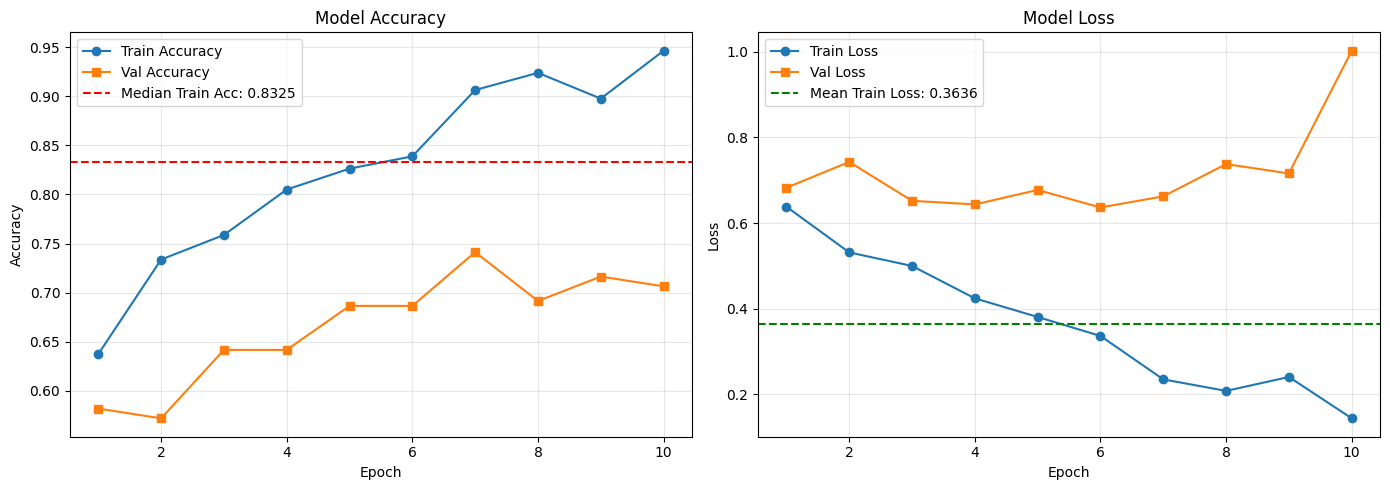

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(range(1, num_epochs + 1), history['acc'], 'o-', label='Train Accuracy')
ax1.plot(range(1, num_epochs + 1), history['val_acc'], 's-', label='Val Accuracy')
ax1.axhline(y=median_train_acc, color='r', linestyle='--', label=f'Median Train Acc: {median_train_acc:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(range(1, num_epochs + 1), history['loss'], 'o-', label='Train Loss')
ax2.plot(range(1, num_epochs + 1), history['val_loss'], 's-', label='Val Loss')
ax2.axhline(y=np.mean(history['loss']), color='g', linestyle='--', 
            label=f'Mean Train Loss: {np.mean(history["loss"]):.4f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Augmented training transforms
train_transforms_aug = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Create new dataset with augmentation
train_dataset_aug = HairTypeDataset(
    data_dir='./data/train',
    transform=train_transforms_aug
)

train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=batch_size,
    shuffle=True
)

print(f"Created augmented training dataset with {len(train_dataset_aug)} samples")

Found classes: ['curly', 'straight']
Class to index mapping: {'curly': 0, 'straight': 1}
Total images loaded: 800
Created augmented training dataset with 800 samples


In [22]:
# Continue training for 10 more epochs with augmentation
num_epochs_aug = 10
history_aug = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs_aug):
    # Training phase with augmentation
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset_aug)
    epoch_acc = correct_train / total_train
    history_aug['loss'].append(epoch_loss)
    history_aug['acc'].append(epoch_acc)

    # Validation phase (same as before)
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history_aug['val_loss'].append(val_epoch_loss)
    history_aug['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs_aug}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6712, Acc: 0.6475, Val Loss: 0.5733, Val Acc: 0.7114
Epoch 2/10, Loss: 0.5766, Acc: 0.6950, Val Loss: 0.5828, Val Acc: 0.6816
Epoch 3/10, Loss: 0.5242, Acc: 0.7388, Val Loss: 0.6114, Val Acc: 0.6965
Epoch 4/10, Loss: 0.5420, Acc: 0.7225, Val Loss: 0.6051, Val Acc: 0.6915
Epoch 5/10, Loss: 0.5081, Acc: 0.7475, Val Loss: 0.5753, Val Acc: 0.6866
Epoch 6/10, Loss: 0.5188, Acc: 0.7137, Val Loss: 0.6098, Val Acc: 0.6915
Epoch 7/10, Loss: 0.4894, Acc: 0.7512, Val Loss: 0.5675, Val Acc: 0.6667
Epoch 8/10, Loss: 0.4920, Acc: 0.7525, Val Loss: 0.5637, Val Acc: 0.6866
Epoch 9/10, Loss: 0.4651, Acc: 0.7875, Val Loss: 0.6014, Val Acc: 0.7015
Epoch 10/10, Loss: 0.4981, Acc: 0.7712, Val Loss: 0.5904, Val Acc: 0.6965


In [23]:
mean_val_loss = np.mean(history_aug['val_loss'])
print(f"Validation losses with augmentation: {[f'{loss:.4f}' for loss in history_aug['val_loss']]}")
print(f"\nMean validation loss: {mean_val_loss:.4f}")

# Determine closest answer
options = [0.008, 0.08, 0.88, 8.88]
closest_option = min(options, key=lambda x: abs(x - mean_val_loss))
print(f"Closest option: {closest_option}")

Validation losses with augmentation: ['0.5733', '0.5828', '0.6114', '0.6051', '0.5753', '0.6098', '0.5675', '0.5637', '0.6014', '0.5904']

Mean validation loss: 0.5881
Closest option: 0.88


In [24]:
# Last 5 epochs are indices 5-9 (epochs 6-10)
last_5_val_acc = history_aug['val_acc'][5:10]
avg_last_5_val_acc = np.mean(last_5_val_acc)

print(f"Validation accuracies (epochs 6-10): {[f'{acc:.4f}' for acc in last_5_val_acc]}")
print(f"\nAverage validation accuracy (epochs 6-10): {avg_last_5_val_acc:.4f}")

# Determine closest answer
options = [0.08, 0.28, 0.68, 0.98]
closest_option = min(options, key=lambda x: abs(x - avg_last_5_val_acc))
print(f"Closest option: {closest_option}")

Validation accuracies (epochs 6-10): ['0.6915', '0.6667', '0.6866', '0.7015', '0.6965']

Average validation accuracy (epochs 6-10): 0.6886
Closest option: 0.68


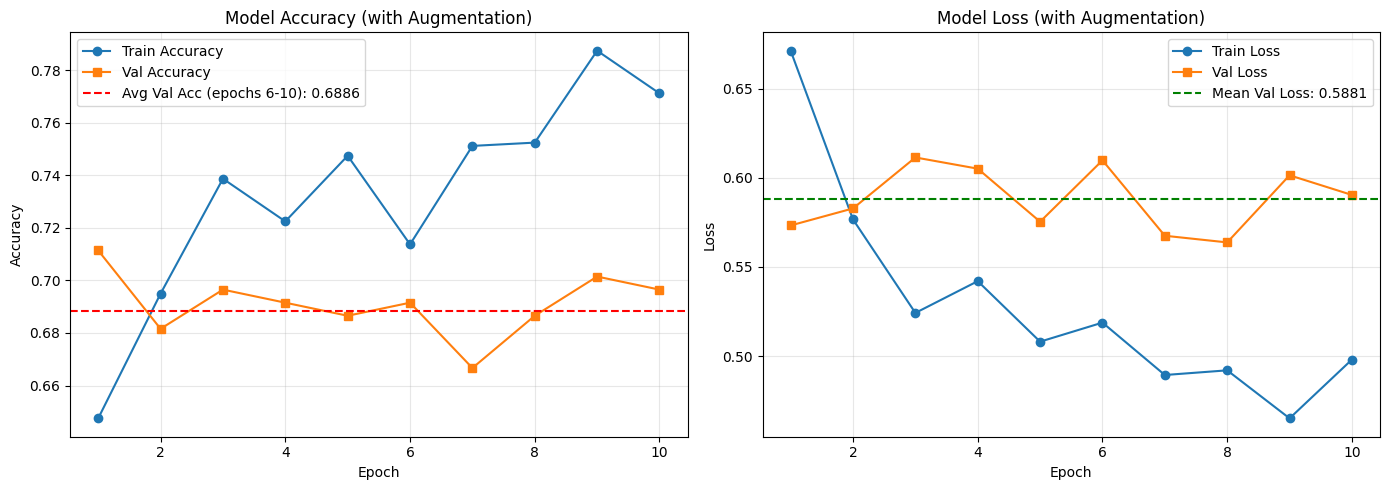

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(range(1, num_epochs_aug + 1), history_aug['acc'], 'o-', label='Train Accuracy')
ax1.plot(range(1, num_epochs_aug + 1), history_aug['val_acc'], 's-', label='Val Accuracy')
ax1.axhline(y=avg_last_5_val_acc, color='r', linestyle='--', 
            label=f'Avg Val Acc (epochs 6-10): {avg_last_5_val_acc:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy (with Augmentation)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(range(1, num_epochs_aug + 1), history_aug['loss'], 'o-', label='Train Loss')
ax2.plot(range(1, num_epochs_aug + 1), history_aug['val_loss'], 's-', label='Val Loss')
ax2.axhline(y=mean_val_loss, color='g', linestyle='--', 
            label=f'Mean Val Loss: {mean_val_loss:.4f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss (with Augmentation)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()